## Imports

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, roc_auc_score, balanced_accuracy_score, fbeta_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, precision_score, recall_score

%matplotlib inline

## Preparing diabetes dataset

In [52]:
# Load dataset
data_original = pd.read_csv('dataset/diabetes_original.csv')
data_outlier_removed = pd.read_csv('dataset/data_outlier_removed.csv')

## USING ORIGINAL DATASET

In [53]:
### DATA PREPROCESSING

# Replace 0 values from biological parameter with the least 0 values with NaN
data_original[['Glucose', 'BloodPressure', 'BMI']] = data_original[['Glucose', 'BloodPressure', 'BMI']].replace(0, np.nan)

# Convert to numpy array
data = data_original.to_numpy()

# Extract features (X) and labels (y)
X, y = data[:, :data.shape[1]-1], data[:, data.shape[1]-1]
y = y.astype(int)

# First split: 80% for training and 20% for testing with stratified
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(strat_split.split(X, y))

X_train_full, X_test = X[train_idx], X[test_idx]
y_train_full, y_test = y[train_idx], y[test_idx]

# Second split: 80% of the 80% for training, and 20% for validation
strat_split_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(strat_split_val.split(X_train_full, y_train_full))

X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

print('Class label counts:', np.bincount(y))
print('X.shape:', X.shape)
print('y.shape:', y.shape)

# Output the shapes to confirm the split
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)
print('y_test shape:', y_test.shape)

# Verify class distribution
print('Class distribution in y_train:', np.bincount(y_train))
print('Class distribution in y_val:', np.bincount(y_val))
print('Class distribution in y_test:', np.bincount(y_test))

Class label counts: [500 268]
X.shape: (768, 8)
y.shape: (768,)
X_train shape: (491, 8)
X_val shape: (123, 8)
X_test shape: (154, 8)
y_train shape: (491,)
y_val shape: (123,)
y_test shape: (154,)
Class distribution in y_train: [320 171]
Class distribution in y_val: [80 43]
Class distribution in y_test: [100  54]


In [54]:
# Data preprocessing pipeline
preproc_pl = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                       ('std_scaler', StandardScaler())])

# Fit and transform the training data, then apply the same transformation to validation set
X_train = preproc_pl.fit_transform(X_train)
X_val = preproc_pl.transform(X_val)
X_test = preproc_pl.fit_transform(X_test) # Fit own preprocessing to test data to avoid data leaking

### Defining the Perceptron model

In [55]:
def plot_conf_matrix(y_true, y_pred):
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    # Compute confusion matrix
    cmat = confusion_matrix(y_true, y_pred)
    # Plot the confusion matrix using seaborn heatmap for visualization
    plt.figure(figsize=(6, 4))
    sns.heatmap(cmat, annot=True, fmt='d', cmap='Blues', cbar=False)
    # Labeling the axes and the title
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    # Show the plot
    plt.show()

def calculate_f1(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, pos_label=1)
    return f1

def calculate_f10(y_true, y_pred):
    f10 = fbeta_score(y_true, y_pred, beta=10, pos_label=1)
    return f10

In [56]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class PerceptronBaseline():
    def __init__(self, num_features):
        self.num_features = num_features
        # Using zero initialization
        self.weights = torch.zeros(num_features, 1, 
                                   dtype=torch.float32, device=device)
        self.bias = torch.zeros(1, dtype=torch.float32, device=device)
        self.ones = torch.ones(1)
        self.zeros = torch.zeros(1)

    def forward(self, x):
        linear = torch.mm(x, self.weights) + self.bias # y = wx + b
        predictions = torch.where(linear > 0., self.ones, self.zeros) # Apply heavy step function
        return predictions
        
    def backward(self, x, y):  
        predictions = self.forward(x)
        errors = y - predictions
        return errors
        
    def train(self, x, y, epochs):
        for e in range(epochs):
            for i in range(y.shape[0]):
                # use view because backward expects a matrix (i.e., 2D tensor)
                errors = self.backward(x[i].reshape(1, self.num_features), y[i]).reshape(-1)
                self.weights += (errors * x[i]).reshape(self.num_features, 1)
                self.bias += errors
                
    def evaluate(self, x, y):
        predictions = self.forward(x).reshape(-1)
        # Assuming binary classification, convert predictions to binary (0 or 1)
        predicted_classes = (predictions >= 0.5).int()  # Thresholding at 0.5
        accuracy = torch.sum(predicted_classes == y).float() / y.shape[0]
        y_true = y.cpu().numpy()
        y_pred = predicted_classes.cpu().numpy()
        return accuracy, y_pred

### Training the Perceptron

In [57]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32, device=device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32, device=device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

In [17]:
ppn_baseline = PerceptronBaseline(num_features=X_train_tensor.shape[1]) # Use 8 features
ppn_baseline.train(X_train_tensor, y_train_tensor, epochs=500)

print('Model parameters:')
print('Weights: %s' % ppn_baseline.weights)
print('Bias: %s' % ppn_baseline.bias)

val_acc, y_pred_val = ppn_baseline.evaluate(X_val_tensor, y_val_tensor)
print('Val set accuracy: %.2f%%' % (val_acc*100))
print('Balanced Acc: ', balanced_accuracy_score(y_val, y_pred_val))
print('F1 score', calculate_f1(y_val, y_pred_val))

Model parameters:
Weights: tensor([[ 3.4235],
        [ 5.1018],
        [-3.8054],
        [-0.4727],
        [-2.8642],
        [ 0.0206],
        [-1.6059],
        [ 1.4977]])
Bias: tensor([-3.])
Val set accuracy: 73.98%
Balanced Acc:  0.7193313953488372
F1 score 0.6363636363636364


### Model Optimization

In [18]:
# Use Sigmoid activation function and zero initialization
class PerceptronZeroSigmoid(PerceptronBaseline):
    def __init__(self, num_features):
        super().__init__(num_features)

    def forward(self, x):
        linear = torch.mm(x, self.weights) + self.bias
        # Apply sigmoid activation function
        predictions = torch.sigmoid(linear)
        return predictions

ppn_with_zero_sigmoid = PerceptronZeroSigmoid(num_features=X_train_tensor.shape[1])
ppn_with_zero_sigmoid.train(X_train_tensor, y_train_tensor, epochs=500)

val_acc, y_pred_val = ppn_with_zero_sigmoid.evaluate(X_val_tensor, y_val_tensor)
print('Val set accuracy: %.2f%%' % (val_acc*100))
print('Balanced Acc: ', balanced_accuracy_score(y_val, y_pred_val))
print('F1 score', calculate_f1(y_val, y_pred_val))
    

Val set accuracy: 75.61%
Balanced Acc:  0.7049418604651163
F1 score 0.6052631578947368


In [19]:
# Change the initializer to random 
class PerceptronSigmoid(PerceptronBaseline):
    def __init__(self, num_features):
        super().__init__(num_features)
        # Initialize weights and bias with random values
        self.weights = torch.randn(num_features, 1, dtype=torch.float32, device=device)
        self.bias = torch.randn(1, dtype=torch.float32, device=device)

    def forward(self, x):
        linear = torch.mm(x, self.weights) + self.bias
        # Apply sigmoid activation function
        predictions = torch.sigmoid(linear)
        return predictions
    
ppn_with_sigmoid = PerceptronSigmoid(num_features=X_train_tensor.shape[1])
ppn_with_sigmoid.train(X_train_tensor, y_train_tensor, epochs=500)

val_acc, y_pred_val = ppn_with_sigmoid.evaluate(X_val_tensor, y_val_tensor)
print('Val set accuracy: %.2f%%' % (val_acc*100))
print('Balanced Acc: ', balanced_accuracy_score(y_val, y_pred_val))
print('F1 score', calculate_f1(y_val, y_pred_val))

Val set accuracy: 75.61%
Balanced Acc:  0.7049418604651163
F1 score 0.6052631578947368


In [20]:
# Initialize with glorot initializer
class PerceptronWithGlorotInit(PerceptronSigmoid):
    def __init__(self, num_features):
        super().__init__(num_features)
        limit = np.sqrt(6 / (num_features + 1))  # Glorot initialization formula
        # Uniformly initialize the weights between [-limit, limit]
        self.weights = torch.FloatTensor(num_features, 1).uniform_(-limit, limit).to(device)
        # Initialize bias in a similar way (optional, often bias is initialized to zero)
        self.bias = torch.FloatTensor(1).uniform_(-limit, limit).to(device)

ppn_3 = PerceptronWithGlorotInit(num_features=X_train_tensor.shape[1])
ppn_3.train(X_train_tensor, y_train_tensor, epochs=500)

val_acc, y_pred_val = ppn_3.evaluate(X_val_tensor, y_val_tensor)
print('Val set accuracy: %.2f%%' % (val_acc*100))
print('Balanced Acc: ', balanced_accuracy_score(y_val, y_pred_val))
print('F1 score', calculate_f1(y_val, y_pred_val))


Val set accuracy: 75.61%
Balanced Acc:  0.7049418604651163
F1 score 0.6052631578947368


In [21]:
class PerceptronWithLearningRate(PerceptronSigmoid):
    def __init__(self, num_features, learning_rate=0.01):
        super().__init__(num_features)
        self.learning_rate = learning_rate

    def train(self, x, y, epochs):
        for e in range(epochs):
            for i in range(y.shape[0]):
                errors = self.backward(x[i].reshape(1, self.num_features), y[i]).reshape(-1)                
                # Update the weights and bias using the learning rate
                self.weights += self.learning_rate * (errors * x[i]).reshape(self.num_features, 1)
                self.bias += self.learning_rate * errors

lr = [1e-4, 1e-3, 5e-3, 2e-3, 1e-2, 0.1, 1]
for learning_rate in lr:
    perceptron_lr = PerceptronWithLearningRate(num_features=X_train_tensor.shape[1], learning_rate=learning_rate)
    perceptron_lr.train(X_train_tensor, y_train_tensor, epochs=500)
    val_acc, y_pred_val = perceptron_lr.evaluate(X_val_tensor, y_val_tensor)
    print('Learning rate :', learning_rate)
    print('Val set accuracy: %.2f%%' % (val_acc*100))
    print('Balanced Acc: ', balanced_accuracy_score(y_val, y_pred_val))
    print('F1 score', calculate_f1(y_val, y_pred_val))
    print('='*50)

Learning rate : 0.0001
Val set accuracy: 82.93%
Balanced Acc:  0.7934593023255814
F1 score 0.7341772151898734
Learning rate : 0.001
Val set accuracy: 79.67%
Balanced Acc:  0.757703488372093
F1 score 0.6835443037974683
Learning rate : 0.005
Val set accuracy: 79.67%
Balanced Acc:  0.757703488372093
F1 score 0.6835443037974683
Learning rate : 0.002
Val set accuracy: 79.67%
Balanced Acc:  0.757703488372093
F1 score 0.6835443037974683
Learning rate : 0.01
Val set accuracy: 79.67%
Balanced Acc:  0.757703488372093
F1 score 0.6835443037974683
Learning rate : 0.1
Val set accuracy: 81.30%
Balanced Acc:  0.7755813953488373
F1 score 0.7088607594936709
Learning rate : 1
Val set accuracy: 75.61%
Balanced Acc:  0.7049418604651163
F1 score 0.6052631578947368


Val set accuracy: 82.93%
Balanced Acc:  0.7880813953488373
F1 score 0.7272727272727273
Precision: 0.8235294117647058
Recall: 0.6511627906976745


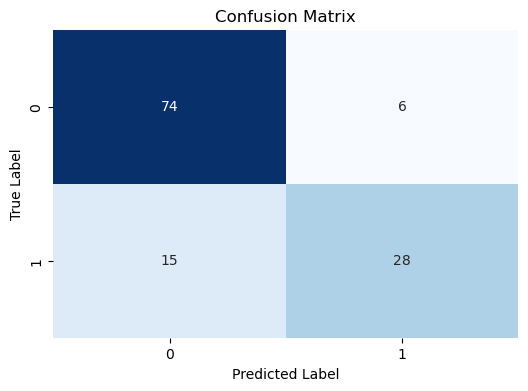

In [23]:
ppn_4 = PerceptronWithLearningRate(num_features=X_train_tensor.shape[1], learning_rate=0.0001)
ppn_4.train(X_train_tensor, y_train_tensor, epochs=500)
val_acc, y_pred_val = ppn_4.evaluate(X_val_tensor, y_val_tensor)
print('Val set accuracy: %.2f%%' % (val_acc*100))
print('Balanced Acc: ', balanced_accuracy_score(y_val, y_pred_val))
print('F1 score', calculate_f1(y_val, y_pred_val))
plot_conf_matrix(y_val, y_pred_val)

Val set accuracy: 82.11%
Balanced Acc:  0.7818313953488372
F1 score 0.7179487179487181
Precision: 0.8
Recall: 0.6511627906976745


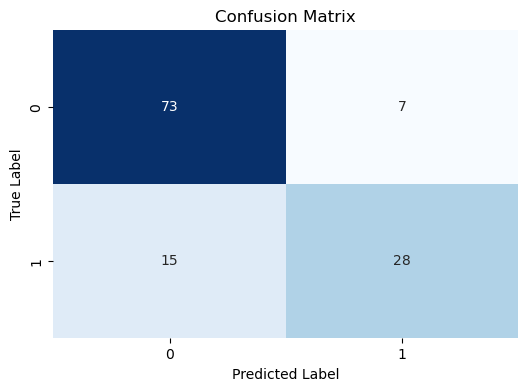

In [31]:
# Perceptron with reegularization / penalty
class PerceptronWithPenalty(PerceptronWithLearningRate):
    def __init__(self, num_features, learning_rate=0.001, l1_lambda=0.1):
        # Inherit from PerceptronWithLearningRate
        super().__init__(num_features, learning_rate)
        self.l1_lambda = l1_lambda  
    
    def train(self, x, y, epochs):
        for e in range(epochs):
            for i in range(y.shape[0]):
                # Use the backward method to calculate errors
                errors = self.backward(x[i].reshape(1, self.num_features), y[i]).reshape(-1)
                
                # Update the weights and bias using the learning rate
                self.weights += self.learning_rate * (errors * x[i]).reshape(self.num_features, 1)
                self.bias += self.learning_rate * errors

                # Apply L1 regularization (Lasso)
                if self.l1_lambda > 0:
                    self.weights -= self.l1_lambda * torch.sign(self.weights)

ppn_5 = PerceptronWithPenalty(num_features=X_train_tensor.shape[1], learning_rate=0.0001, l1_lambda=1e-7)
ppn_5.train(X_train_tensor, y_train_tensor, epochs=500)
val_acc, y_pred_val = ppn_5.evaluate(X_val_tensor, y_val_tensor)
print('Val set accuracy: %.2f%%' % (val_acc*100))
print('Balanced Acc: ', balanced_accuracy_score(y_val, y_pred_val))
print('F1 score', calculate_f1(y_val, y_pred_val))
plot_conf_matrix(y_val, y_pred_val)

### Evaluating the model with test set

Test set accuracy: 70.13%
Balanced Acc:  0.6507407407407407
Precision: 0.5909090909090909
Recall: 0.48148148148148145


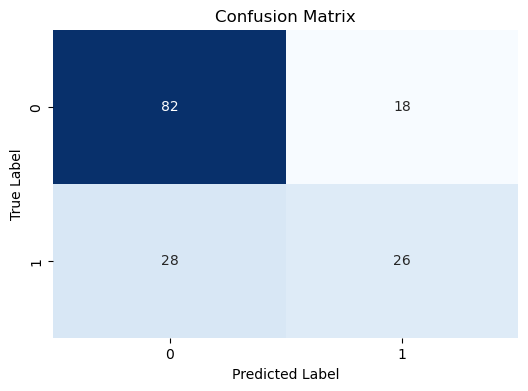

In [32]:
test_acc, y_pred_test = ppn_5.evaluate(X_test_tensor, y_test_tensor)
print('Test set accuracy: %.2f%%' % (test_acc*100))
print('Balanced Acc: ', balanced_accuracy_score(y_test, y_pred_test))
plot_conf_matrix(y_test, y_pred_test)

## USING CLEANED DATASET

In [37]:
## Data preprocessing
data_outlier_removed[['Glucose', 'BloodPressure', 'BMI']] = data_outlier_removed[['Glucose', 'BloodPressure', 'BMI']].replace(0, np.nan)

# Drop rows that contain any NaN values
#data = data.dropna(subset=['Glucose', 'BloodPressure', 'BMI'])

# Convert to numpy array
data = data_outlier_removed.to_numpy()

# Extract features (X) and labels (y)
X, y = data[:, :data.shape[1]-1], data[:, data.shape[1]-1]
y = y.astype(int)

# First split: 80% for training and 20% for testing with stratified
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(strat_split.split(X, y))

X_train_full, X_test = X[train_idx], X[test_idx]
y_train_full, y_test = y[train_idx], y[test_idx]

# Second split: 80% of the 80% for training, and 20% for validation
strat_split_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(strat_split_val.split(X_train_full, y_train_full))

X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

print('Class label counts:', np.bincount(y))
print('X.shape:', X.shape)
print('y.shape:', y.shape)

# Output the shapes to confirm the split
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)
print('y_test shape:', y_test.shape)

# Verify class distribution
print('Class distribution in y_train:', np.bincount(y_train))
print('Class distribution in y_val:', np.bincount(y_val))
print('Class distribution in y_test:', np.bincount(y_test))

Class label counts: [500 268]
X.shape: (768, 8)
y.shape: (768,)
X_train shape: (491, 8)
X_val shape: (123, 8)
X_test shape: (154, 8)
y_train shape: (491,)
y_val shape: (123,)
y_test shape: (154,)
Class distribution in y_train: [320 171]
Class distribution in y_val: [80 43]
Class distribution in y_test: [100  54]


In [38]:
# Data preprocessing pipeline
preproc_pl = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                       ('std_scaler', StandardScaler())])

# Fit and transform the training data, then apply the same transformation to validation and test sets
X_train = preproc_pl.fit_transform(X_train)
X_val = preproc_pl.transform(X_val)
X_test = preproc_pl.fit_transform(X_test) # Fit own preprocessing to test data to avoid data leaking

In [39]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32, device=device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32, device=device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

Val set accuracy: 83.74%
Balanced Acc:  0.7997093023255815
F1 score 0.7435897435897435
Precision: 0.8285714285714286
Recall: 0.6744186046511628


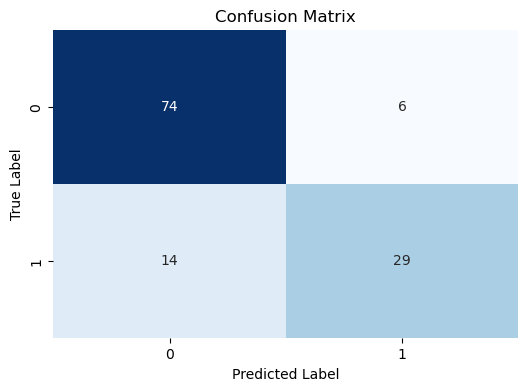

In [40]:
ppn_with_clened_data = PerceptronWithLearningRate(num_features=X_train_tensor.shape[1], learning_rate=0.0001)
ppn_with_clened_data.train(X_train_tensor, y_train_tensor, epochs=500)
val_acc, y_pred_val = ppn_with_clened_data.evaluate(X_val_tensor, y_val_tensor)
print('Val set accuracy: %.2f%%' % (val_acc*100))
print('Balanced Acc: ', balanced_accuracy_score(y_val, y_pred_val))
print('F1 score', calculate_f1(y_val, y_pred_val))
plot_conf_matrix(y_val, y_pred_val)

### Evaluate on Test Data

Test set accuracy: 72.73%
Balanced Acc:  0.6877777777777778
Precision: 0.625
Recall: 0.5555555555555556


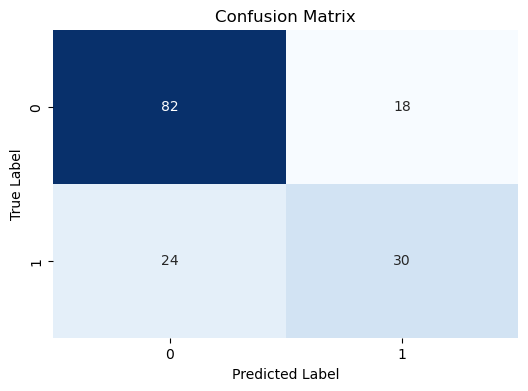

In [41]:
test_acc, y_pred_test = ppn_with_clened_data.evaluate(X_test_tensor, y_test_tensor)
print('Test set accuracy: %.2f%%' % (test_acc*100))
print('Balanced Acc: ', balanced_accuracy_score(y_test, y_pred_test))
plot_conf_matrix(y_test, y_pred_test)

## SUMMARY

### Summary of Model Optimization (with Original Data)

Using original dataset (after preprocessed):
* Perceptron baseline model:
    - acc: 73.17
    - balanced acc: 67.54
    - f1 score: 0.56

* Sigmoid activation function with zero initialization:
    - acc: 73.98
    - balanced acc: 67.63
    - f1 score: 0.56

* Sigmoid activation function with random initialization:
    - acc: 75.61
    - balanced acc: 70.5 
    - f1 score: 0.61

* Sigmoid activation function with glorot initialization:
    - acc: 75.61
    - balanced acc: 70.5 
    - f1 score: 0.61

* Perceptron with learning rate:
    - acc: 82.11
    - balanced acc: 77.65 
    - f1 score: 0.71 

* Perceptron with penalty:
    - acc: 79.67
    - balanced acc: 75.77
    - f1: 0.68

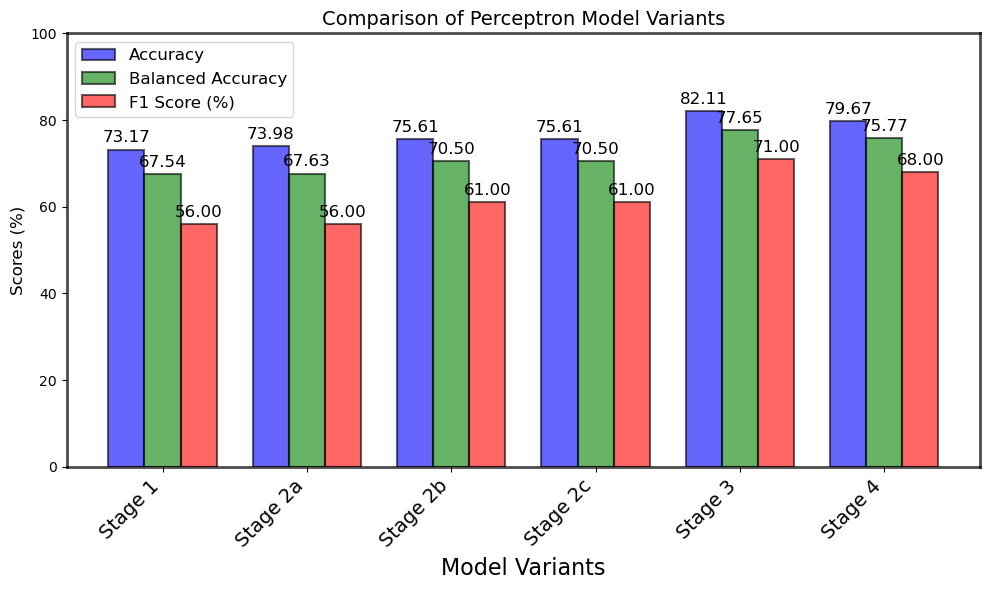

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the different models
models = ['Stage 1', 'Stage 2a', 'Stage 2b', 'Stage 2c', 'Stage 3', 'Stage 4']
accuracy = [73.17, 73.98, 75.61, 75.61, 82.11, 79.67]
balanced_accuracy = [67.54, 67.63, 70.5, 70.5, 77.65, 75.77]
f1_score = [0.56, 0.56, 0.61, 0.61, 0.71, 0.68]
f1_score_percent = [f1 * 100 for f1 in f1_score]  # Convert F1 scores to percentage

# Plotting
x = np.arange(len(models))  # label locations
width = 0.25  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot for each metric with transparency (alpha) and border (edgecolor and linewidth)
bars1 = ax.bar(x - width, accuracy, width, label='Accuracy', color='b', alpha=0.6, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x, balanced_accuracy, width, label='Balanced Accuracy', color='g', alpha=0.6, edgecolor='black', linewidth=1.5)
bars3 = ax.bar(x + width, f1_score_percent, width, label='F1 Score (%)', color='r', alpha=0.6, edgecolor='black', linewidth=1.5)

# Set y-axis limit to 100
ax.set_ylim(0, 100)

# Labels, title, and legend
ax.set_xlabel('Model Variants', fontsize=16)  # Increased font size for x-axis label
ax.set_ylabel('Scores (%)', fontsize=12)      # Default font size for y-axis label
ax.set_title('Comparison of Perceptron Model Variants', fontsize=14)  # Default title font size
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right", fontsize=14)  # Increased font size for tick labels on x-axis
ax.legend(fontsize=12, loc='upper left')  # Move legend to top left corner

# Adding value labels on top of bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # offset for text
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=12)  # Default font size for value labels

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

# Make the plot background transparent
ax.set_facecolor((1, 1, 1, 0.3))  # Make the plot background semi-transparent (30% opacity)

# Add a border with transparency and color adjustment
for spine in ax.spines.values():
    spine.set_edgecolor('black')  # Border color
    spine.set_alpha(0.7)          # Set border transparency (70% opacity)
    spine.set_linewidth(2)        # Set border width

plt.tight_layout()
plt.show()

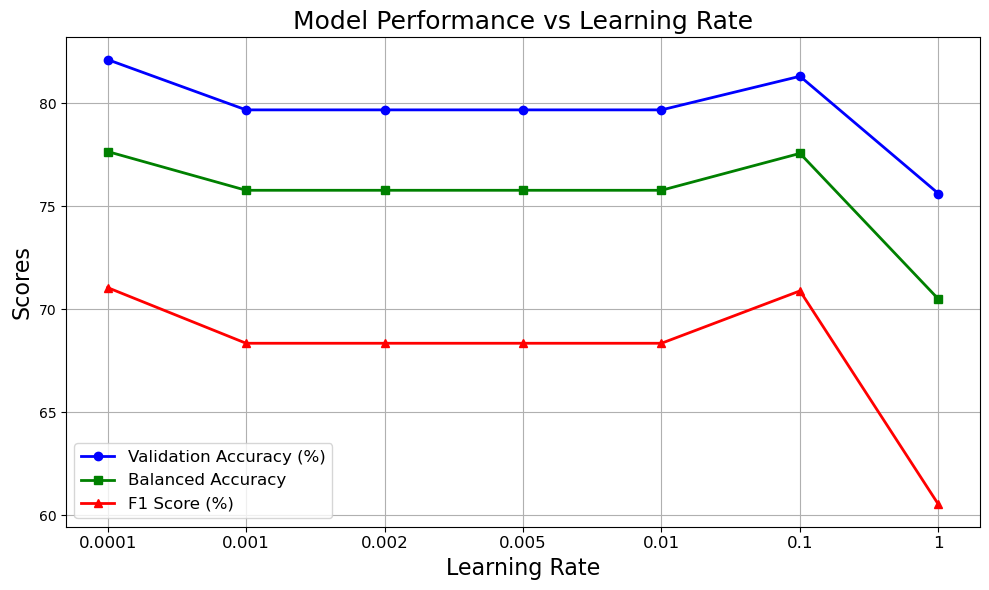

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Data for different learning rates and their corresponding metrics
learning_rates = ['0.0001', '0.001', '0.002', '0.005', '0.01', '0.1', '1']
val_accuracy = [82.11, 79.67, 79.67, 79.67, 79.67, 81.30, 75.61]
balanced_accuracy = [77.65, 75.77, 75.77, 75.77, 75.77, 77.56, 70.49]
f1_score = [0.7105, 0.6835, 0.6835, 0.6835, 0.6835, 0.7089, 0.6053]

# Convert F1 scores to percentage
f1_score_percent = [f1 * 100 for f1 in f1_score]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting each metric
ax.plot(learning_rates, val_accuracy, marker='o', label='Validation Accuracy (%)', color='b', linestyle='-', linewidth=2)
ax.plot(learning_rates, balanced_accuracy, marker='s', label='Balanced Accuracy', color='g', linestyle='-', linewidth=2)
ax.plot(learning_rates, f1_score_percent, marker='^', label='F1 Score (%)', color='r', linestyle='-', linewidth=2)

# Labels and title
ax.set_xlabel('Learning Rate', fontsize=16)
ax.set_ylabel('Scores', fontsize=16)
ax.set_title('Model Performance vs Learning Rate', fontsize=18)
ax.set_xticks(learning_rates)  # Set x-ticks to learning rates
ax.set_xticklabels(learning_rates, fontsize=12)  # Set fontsize for x-tick labels
ax.legend(fontsize=12)

# Adding grid
ax.grid(True)

plt.tight_layout()
plt.show()